In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from itertools import product
import math
import random
import matplotlib.pyplot as plt

random_seed = 0
torch.manual_seed(random_seed)
random.seed(random_seed)

# Prepare dummy data

In [2]:
class FourierDataset(Dataset):
    def __init__(self, n, k, generation_method="uniform_deg", d=None, p_freq=None, n_samples = 100, p_in=0.5):
        self.n = n
        self.k = k

        if generation_method == "uniform_deg":
            self.freq_f = self.uniform_deg_freq(d)
        elif generation_method == "bernouli":
            self.freq_f = self.bernouli_freq(p_freq)
        elif generation_method == "bounded_deg":
            self.freq_f = self.bounded_degree_freq(d)
        else:
            raise Exception(f'"{generation_method}" is not a generation method for FourierDataset.')

        self.amp_f = torch.FloatTensor(k).uniform_(-1, 1)

        self.X = (torch.rand(n_samples, n) < p_in).float()
        self.y = self.compute_y(self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def compute_y(self, X):
        in_dot_f = X @ torch.t(self.freq_f)
        return torch.sum(torch.where(in_dot_f % 2 == 1, -1, 1) * self.amp_f, axis = -1) / 2**(self.n/2)
    
    def bounded_degree_freq(self, d):
        freqs = torch.zeros(self.k, self.n)
        one_indices = [(i, random.randrange(self.n)) for j in range(d) for i in range(self.k)]
        freqs[list(zip(*one_indices))] = 1.0
        return freqs

    def bernouli_freq(self, p):
        return (torch.rand(self.k, self.n) < p).float()

    def uniform_deg_freq(self, d):
        freqs = torch.zeros(self.k, self.n)
        one_rows, one_cols = [], []
        for i in range(self.k):
            deg = random.randint(1, d)
            one_rows.extend([i]*deg)
            one_cols.extend(random.sample(range(self.n), deg))
        freqs[one_rows, one_cols] = 1.0
        return freqs

p_freq = 0.2
d = 4

n = 50
k = 40
B = 10
# freq_f = bernouli_freq(n, k, p_freq)
# # freq_f = bounded_degree_freq(n, k, d)
# amp_f = torch.rand(k).float()

dataset = FourierDataset(n, k, d=d, n_samples=1000)
test_ds = FourierDataset(n=10, k=10, d=4, n_samples=100)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 0.]])
tensor([ 0.0876,  0.7197,  0.2393,  0.5120, -0.2003,  0.5092, -0.0877, -0.1442,
        -0.7691, -0.3046])


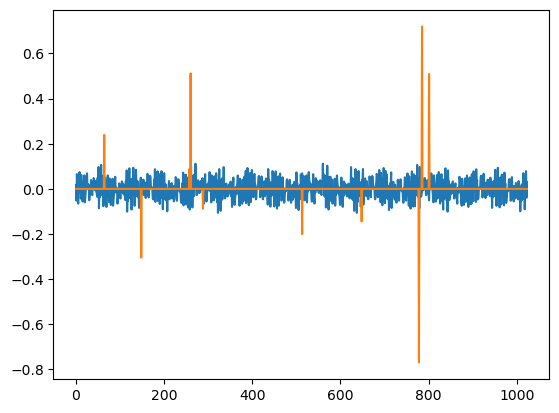

In [9]:
def hadamard_matrix(n, normalize=False):
    '''
    Compute H_n, Hadamard matrix
    '''
    H1 = torch.asarray([[1.,1.], [1.,-1.]])
    H = torch.asarray([1.])
    for i in range(n):
        H = torch.kron(H, H1)
    if normalize:
        H = (1 / math.sqrt(2**n)) * H
    return H

# hadamard_matrix(3, normalize=False)

print(test_ds.freq_f)
print(test_ds.amp_f)
all_inputs = torch.asarray(list((product((0.0,1.0), repeat=10))))
landscape = test_ds.compute_y(all_inputs)
# landscape = landscape[torch.randperm(landscape.shape[0])]
H = hadamard_matrix(10, normalize=True)
spectrum = H @ landscape
plt.plot(list(range(2**10)), landscape.numpy())
plt.plot(list(range(2**10)), spectrum.numpy())

# Train Model

In [10]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

In [22]:
def get_sample_inputs(n, b):
    hash_sigma = (torch.rand(b, n) < 0.5).float() # multivariate bernouli with p=0.5
    hash_inputs = torch.asarray(list((product((0.0,1.0), repeat=b))))

    sample_inputs = hash_inputs @ hash_sigma
    return sample_inputs

    
def train_normal_model(model, train_loader, val_loader, config, device="cuda"):
    if config["add_hadamard_loss"]:
        H = hadamard_matrix(config["b"], normalize=True).to(device)
        n = next(iter(val_loader))[0].shape[1] # original space dimension

    logs = []
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    for epoch in range(config["num_epochs"]):
        model.train()
        batch_train_loss, batch_hadamard_loss = [], []
        log = {}
        for X, y in train_loader:
            optim.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = F.mse_loss(y, y_hat)
            batch_train_loss.append(loss)

            if config["add_hadamard_loss"]:
                # Find the sample inputs using the hashing scheme
                sample_inputs = get_sample_inputs(n, config["b"])
                sample_inputs = sample_inputs.to(device)

                # Compute the Hadamard transform of sample_inputs and add to loss
                X = model(sample_inputs)
                Y = H @ X

                hadamard_loss = F.l1_loss(Y, torch.zeros_like(Y))
                batch_hadamard_loss.append(hadamard_loss)
                loss += config["hadamard_lambda"] * hadamard_loss

            loss.backward()
            optim.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                val_loss += F.mse_loss(y, y_hat).item()
            val_loss /= len(val_loader)
            print(f"#{epoch} - Validation Loss: {val_loss:.3f}")
        
        logs.append({
            'val_loss': val_loss,
            'train_loss': torch.mean(torch.stack(batch_train_loss)).item(),
            'hadamard_loss': -1.0 if len(batch_hadamard_loss) == 0 else torch.mean(torch.stack(batch_hadamard_loss)).item(),
        })
    return logs

In [30]:
p_test = 0.25
batch_size = 64

test_size = int(p_test * len(dataset))
train_ds, val_ds = random_split(dataset, lengths=[len(dataset) - test_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

In [31]:
torch.manual_seed(random_seed)

train_config = {
    "add_hadamard_loss": True, 
    "b": 8,
    "lr": 1e-3, 
    "weight_decay": 0.0, 
    "hadamard_lambda": 0.5, 
    "num_epochs": 20,
    "batch_size": batch_size,
}


in_dim = dataset.X.shape[1]
model = FCN(in_dim, 2)
logs = train_normal_model(model, train_loader, val_loader, config=train_config)

#0 - Validation Loss: 0.017
#1 - Validation Loss: 0.006
#2 - Validation Loss: 0.004
#3 - Validation Loss: 0.002
#4 - Validation Loss: 0.002
#5 - Validation Loss: 0.001
#6 - Validation Loss: 0.001
#7 - Validation Loss: 0.001
#8 - Validation Loss: 0.001
#9 - Validation Loss: 0.001
#10 - Validation Loss: 0.001
#11 - Validation Loss: 0.001
#12 - Validation Loss: 0.000
#13 - Validation Loss: 0.000
#14 - Validation Loss: 0.000
#15 - Validation Loss: 0.000
#16 - Validation Loss: 0.000
#17 - Validation Loss: 0.000
#18 - Validation Loss: 0.000
#19 - Validation Loss: 0.000


In [27]:
logs

[{'val_loss': 0.01564370235428214,
  'train_loss': 0.1253940910100937,
  'hadamard_loss': 0.132624089717865},
 {'val_loss': 0.006901248823851347,
  'train_loss': 0.045595478266477585,
  'hadamard_loss': 0.07218015193939209},
 {'val_loss': 0.004442087607458234,
  'train_loss': 0.03215628117322922,
  'hadamard_loss': 0.05519683659076691},
 {'val_loss': 0.0031907708034850657,
  'train_loss': 0.024886703118681908,
  'hadamard_loss': 0.04341784119606018},
 {'val_loss': 0.002246401651063934,
  'train_loss': 0.020796380937099457,
  'hadamard_loss': 0.03771182894706726},
 {'val_loss': 0.0018197019526269287,
  'train_loss': 0.018477145582437515,
  'hadamard_loss': 0.03384948521852493},
 {'val_loss': 0.0014635519473813474,
  'train_loss': 0.016377177089452744,
  'hadamard_loss': 0.03016410768032074},
 {'val_loss': 0.0015034509415272623,
  'train_loss': 0.014350557699799538,
  'hadamard_loss': 0.0262770876288414},
 {'val_loss': 0.0009648349514463916,
  'train_loss': 0.01245182752609253,
  'hadama

## Test hashing

In [ ]:
import copy

n = 14
k = 10
d = 4

main_signal = FourierDataset(n, k, d=d)

for b in range(2, n):
    H = hadamard_matrix(b, normalize=True)
    sample_inputs = get_sample_inputs(n, b)
    hashed_freqs = H @ main_signal.compute_y(sample_inputs)
    # Plot
    plt.figure(b)
    plt.plot(list(range(2**b)), landscape.numpy())
    